In [ ]:
import pandas as pd
import ast
import numpy as np

# 文件路径
file_path = "/data2/public_data/qwen_mix_sft_32K/all.parquet"

# 1. 加载数据
try:
    df = pd.read_parquet(file_path)
except Exception as e:
    print(f"Error reading parquet file: {e}")
    # 为了演示，创建一个模拟的DataFrame
    data = {
        'id': ['1', '2', '3', '4', '5'],
        'context': [
            '...S3Provider.put_bucket_inventory_configuration...', 
            '...This is a math problem: x^2+2x+1=0...', 
            '...Define the term "reinforcement learning"...',
            '...Please implement a quick sort algorithm...',
            '...localstack.services.s3.v3.provider.S3Provider...'
        ],
        'question': [
            'Please complete the put_bucket_inventory_configuration function code.', 
            'Solve the quadratic equation.', 
            'What is reinforcement learning?',
            'Complete the quicksort function.',
            'Refactor the S3Provider class.'
        ],
        'metadata': [
            '{"task": "Code", "length": 26896, "source": "CoLT-132K"}',
            '{"task": "Math", "length": 1000, "source": "AIME"}',
            '{"task": "QA", "length": 500, "source": "Wiki"}',
            '{"task": "Code", "length": 5000, "source": "LeetCode"}',
            '{"task": "Code", "length": 3000, "source": "CoLT-132K"}'
        ],
        'answer': ['...code...', '...solution...', '...definition...', '...code...', '...code...'],
        'others': [np.array([{'key': '', 'value': ''}], dtype=object)] * 5
    }
    df = pd.DataFrame(data)
    print("Using mock DataFrame for demonstration.")


# 2. 从 metadata 字段中安全提取 'task'
def get_task(metadata_str):
    try:
        # metadata 通常是JSON字符串，需要安全地解析
        if isinstance(metadata_str, str):
            meta_dict = ast.literal_eval(metadata_str)
        elif isinstance(metadata_str, dict):
            meta_dict = metadata_str
        else:
            return None
        return meta_dict.get('task')
    except Exception:
        return None

df['task_type'] = df['metadata'].apply(get_task)

# 3. 筛选并查看任务分布
task_counts = df['task_type'].value_counts()
print("\n--- 任务类型分布 ---")
print(task_counts)

# 移除 task_type 为空或不常见的行，以便分析
df_clean = df.dropna(subset=['task_type'])


--- 任务类型分布 ---
task_type
MultiHop QA      4600
Summarization    4510
Code             4000
Single QA        2890
Name: count, dtype: int64


In [9]:
possible_text_fields = ["text", "context", "input"]
text_field = None
for f in possible_text_fields:
    if f in df_clean.columns:
        text_field = f
        break

if text_field is None:
    raise ValueError("找不到文本字段(text/context/input)，请告诉我字段名。")

print(f"\n使用文本字段: {text_field}")

# 计算文本长度
df_clean["text_len"] = df_clean[text_field].apply(lambda x: len(x) if isinstance(x, str) else 0)

# 目标长度区间
LOW, HIGH = 28000, 36000
TARGET = 32000

df_in_range = df_clean[(df_clean["text_len"] >= LOW) & (df_clean["text_len"] <= HIGH)]
print(f"\n符合长度范围 [{LOW}, {HIGH}] 的样本数: {len(df_in_range)}")

# 选任务数前四的 task_type
top4_tasks = task_counts.head(4).index.tolist()
print("\n选取的四种 task_type:", top4_tasks)

samples = {}

for task in top4_tasks:
    df_task = df_in_range[df_in_range["task_type"] == task]

    if len(df_task) == 0:
        print(f"[警告] task={task} 范围内没有数据 -> 使用全体中最接近32k的样本")
        df_task = df_clean[df_clean["task_type"] == task]

    # 找最接近 32k 的
    chosen = df_task.iloc[(df_task["text_len"] - TARGET).abs().argmin()]
    samples[task] = chosen


# ==========================================================
# 5. 保存 4 条数据到新的 parquet，保持原格式不变
# ==========================================================

save_dir = "/data2/public_data/qwen_mix_sft_32K_4task"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "all.parquet")

# 收集行
selected_rows = [row.to_dict() for row in samples.values()]

# 构建 DataFrame（保持原字段）
df_out = pd.DataFrame(selected_rows)
df_out.to_parquet(save_path, index=False)

print(f"\n✅ 已保存 4 条数据到: {save_path}")


# ==========================================================
# 6. 打印保存的数据内容
# ==========================================================

print("\n--- 保存的数据详情 ---")
for task, row in samples.items():
    txt = row[text_field]
    print(f"\nTask: {task}")
    print(f"ID: {row.get('id', 'N/A')}")
    print(f"Text length: {len(txt)}")
    print(f"Metadata: {row['metadata']}")
    print("--------------------------------------")


使用文本字段: context

符合长度范围 [28000, 36000] 的样本数: 568

选取的四种 task_type: ['MultiHop QA', 'Summarization', 'Code', 'Single QA']

✅ 已保存 4 条数据到: /data2/public_data/qwen_mix_sft_32K_4task/all.parquet

--- 保存的数据详情 ---

Task: MultiHop QA
ID: 
Text length: 31966
Metadata: {'answer_type': 'string', 'context_type': 'list', 'flag': '0', 'length': 8855, 'source': 'LongMIT-128K', 'task': 'MultiHop QA', 'template': ''}
--------------------------------------

Task: Summarization
ID: 543
Text length: 31865
Metadata: {'answer_type': 'string', 'context_type': 'string', 'flag': '0', 'length': 8919, 'source': 'booksum', 'task': 'Summarization', 'template': ''}
--------------------------------------

Task: Code
ID: 
Text length: 32024
Metadata: {'answer_type': 'string', 'context_type': 'dict', 'flag': '0', 'length': 8788, 'source': 'CoLT-132K', 'task': 'Code', 'template': '{"namespace": "","prefix": "","suffix": "","middle": "","function_name": "","invoked_item": ,"code_file_path": "","dependency_file_path": "

In [4]:
import pandas as pd
import ast

# 假设 df_clean 是您已经加载并解析了 'task_type' 的 DataFrame

def build_prompt_text(row):
    """
    根据您的 build_sft_input_and_labels 逻辑构造 prompt_text
    """
    ctx = row.get("context", "") or ""
    q = row.get("question", "") or ""
    meta = row.get("metadata", {}) or {}
    
    # 安全地解析 metadata 获取 flag
    try:
        if isinstance(meta, str):
            meta_dict = ast.literal_eval(meta)
        elif isinstance(meta, dict):
            meta_dict = meta
        else:
            meta_dict = {}
        flag = str(meta_dict.get("flag", "0"))
    except Exception:
        flag = "0" # 默认值

    # 逻辑实现
    if flag == "1":
        prompt_text = q
    else:
        if ctx and q:
            # 对应 ctx.rstrip() + "\n" + q.lstrip()
            # 简化处理：去除前后空白符，中间加换行
            prompt_text = ctx.strip() + "\n" + q.strip()
        else:
            # 对应 (ctx or q)
            prompt_text = (ctx or q)

    return prompt_text.strip()

# 1. 应用函数生成新的输入字段
df_clean['prompt_text'] = df_clean.apply(build_prompt_text, axis=1)

# 2. 准备新的文本和任务标签
texts_new = df_clean['prompt_text'].fillna('')
tasks_new = df_clean['task_type']

# 检查新字段的示例
print("--- 示例 prompt_text ---")
print(df_clean[['task_type', 'prompt_text']].head(2))

--- 示例 prompt_text ---
  task_type                                        prompt_text
0      Code  ...S3Provider.put_bucket_inventory_configurati...
1      Math  ...This is a math problem: x^2+2x+1=0...\nSolv...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TF-IDF 向量化 (针对完整的 prompt_text)
# 保持参数不变，以确保可比性
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None)
X_new = vectorizer.fit_transform(texts_new)

# 2. 使用 PCA 降维
pca = PCA(n_components=50)
X_pca_new = pca.fit_transform(X_new.toarray())

# 3. 抽样
np.random.seed(42)
sample_size = min(len(X_pca_new), 2000)
sample_indices = np.random.choice(len(X_pca_new), sample_size, replace=False)

X_sample_new = X_pca_new[sample_indices]
tasks_sample_new = tasks_new.iloc[sample_indices]

# 4. t-SNE 降维 (注意：如果数据量大，需要耐心等待)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_new = tsne.fit_transform(X_sample_new)

# 5. 可视化
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=X_tsne_new[:, 0], y=X_tsne_new[:, 1],
    hue=tasks_sample_new,
    palette=sns.color_palette("hls", len(tasks_sample_new.unique())),
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Visualization of Full Prompt Embeddings by Task Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt

In [ ]:
import pandas as pd
import os

# --- 之前读取的策略 ---
# 文件路径
file_path = "/data1/public_data/mix_sft_64k/all.parquet"

# 1. 加载数据
try:
    df = pd.read_parquet(file_path)
    print(f"成功加载文件：{file_path}，总行数：{len(df)}")

    # 2. 定义输出路径和文件名
    output_dir = "/data1/public_data/for_debug_mix_sft_64k/"
    output_file_name = "sample_100.parquet"
    output_path = os.path.join(output_dir, output_file_name)

    # 3. 检查输出目录是否存在，如果不存在则创建
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"已创建输出目录：{output_dir}")

    # 4. 随机采样100条数据
    # .sample(n=100) 用于从DataFrame中随机抽取n行
    if len(df) >= 100:
        sampled_df = df.sample(n=100, random_state=42) # 使用random_state确保结果可复现
        print(f"成功采样100条数据。")
        
        # 5. 保存采样结果到指定路径
        sampled_df.to_parquet(output_path, index=False) # index=False 不保存DataFrame的索引
        print(f"采样数据已成功保存到：{output_path}")
    else:
        print(f"警告：数据总行数不足100条 ({len(df)} 条)，将保存所有数据。")
        df.to_parquet(output_path, index=False)
        print(f"所有数据已保存到：{output_path}")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径：{file_path}")
except Exception as e:
    print(f"处理过程中发生错误：{e}")

In [ ]:
import re
import json
from collections import defaultdict

log_path = "/data1/lcm_lab/qqt/SparseAttn/sparseattn/checkpoints/debug_z_12.6/log.out"

# 读取日志
with open(log_path, "r", encoding="utf-8") as f:
    text = f.read()

# step 分块
step_re = re.compile(r"Step\s+(\d+)([\s\S]*?)(?=Step\s+\d+|$)")

# 仅匹配 tensor([...]) 中括号的数字，不捕获 device/grad_fn
pair_re = re.compile(
    r"task id:\s*tensor\(\[(.*?)\]\)\s*,\s*layer sparsity:\s*tensor\(\[(.*?)\]\)",
    re.S
)

def clean_int_list(txt):
    txt = txt.strip()
    return [int(x.strip()) for x in txt.split(",") if x.strip()]

def clean_float_list(txt):
    txt = txt.strip()
    return [float(x.strip()) for x in txt.split(",") if x.strip()]

results = defaultdict(lambda: {"pair_layer_sparsity": []})

for step, block in step_re.findall(text):
    for ids_raw, spars_raw in pair_re.findall(block):
        ids = clean_int_list(ids_raw)
        spars = clean_float_list(spars_raw)
        results[int(step)]["pair_layer_sparsity"].append((ids, spars))

print("解析完成，共解析 step 数量:", len(results))



In [ ]:
len(results)

In [ ]:
import matplotlib.pyplot as plt

task_curve = {}

for step, data in results.items():
    for d in data["per_task_detail"]:
        tid = d["task_id"]
        spars = d["layer_sparsity"]
        task_curve.setdefault(tid, []).append((step, spars))

plt.figure(figsize=(8,5))

has_data = False

for tid, arr in task_curve.items():
    if len(arr) == 0:
        print(f"[WARN] Task {tid} has no data, skip.")
        continue

    arr = sorted(arr)
    xs = [x for x,_ in arr]
    ys = [y for _,y in arr]

    if len(xs) == 0:
        print(f"[WARN] Task {tid} empty after sorting, skip.")
        continue

    plt.plot(xs, ys, label=f"task {tid}")
    has_data = True

if has_data:
    plt.legend()
else:
    print("[ERROR] No task has curves, maybe parsing failed.")

plt.xlabel("Step")
plt.ylabel("Layer sparsity")
plt.title("Task-wise sparsity curve")
plt.show()


In [ ]:
print(task_curve.keys())


In [ ]:
for step, data in results.items():
    pairs = data["pair_layer_sparsity"]
    if not pairs:
        continue
    print(f"Step {step}:")
    for ids, spars in pairs:
        print(" ", list(zip(ids, spars)))


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体（如果需要显示中文）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 解析数据函数
def parse_head_data(data_text):
    """解析头部开关数据"""
    layers = []
    current_layer = None
    
    lines = data_text.strip().split('\n')
    for line in lines:
        if 'head allocate:' in line:
            # 提取头部分配数据
            start_idx = line.find('head allocate:') + len('head allocate: ')
            data_str = line[start_idx:].strip()
            
            # 解析为列表
            data = eval(data_str)
            # 提取32个头的数据
            heads = [item[0] for item in data[0]]
            layers.append(heads)
    
    return np.array(layers, dtype=float)

In [ ]:
single_qa_text = """task_ids: tensor([0], device='cuda:0'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:1'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:1'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:1'), head allocate: [[[1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0]]]

task_ids: tensor([0], device='cuda:1'), head allocate: [[[0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:1'), head allocate: [[[1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:1'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:2'), head allocate: [[[1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:2'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:2'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:2'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0]]]

task_ids: tensor([0], device='cuda:2'), head allocate: [[[1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0]]]

task_ids: tensor([0], device='cuda:2'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:3'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:3'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:5'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:5'), head allocate: [[[1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:5'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:5'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:5'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:5'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:6'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:6'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([0], device='cuda:6'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:6'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([0], device='cuda:6'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0]]]"""


Summarization_text = """task_ids: tensor([2], device='cuda:0'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:1'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:1'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:1'), head allocate: [[[1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:1'), head allocate: [[[0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:1'), head allocate: [[[1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:1'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:2'), head allocate: [[[1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:2'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:2'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:2'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0]]]

task_ids: tensor([2], device='cuda:2'), head allocate: [[[1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0]]]

task_ids: tensor([2], device='cuda:2'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:3'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:3'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:3'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:4'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:5'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:5'), head allocate: [[[1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:5'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:5'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:5'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:5'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:6'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:6'), head allocate: [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]]

task_ids: tensor([2], device='cuda:6'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:6'), head allocate: [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]

task_ids: tensor([2], device='cuda:6'), head allocate: [[[1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0]]]"""



In [11]:
single_qa= parse_head_data(single_qa_text)
Summarization= parse_head_data(Summarization_text)

In [13]:
single_qa

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [16]:
single_qa_array = np.array(single_qa)
summarization_array = np.array(Summarization)

Average Jaccard similarity: 0.941 ± 0.154
Average Cosine similarity:  0.962 ± 0.112


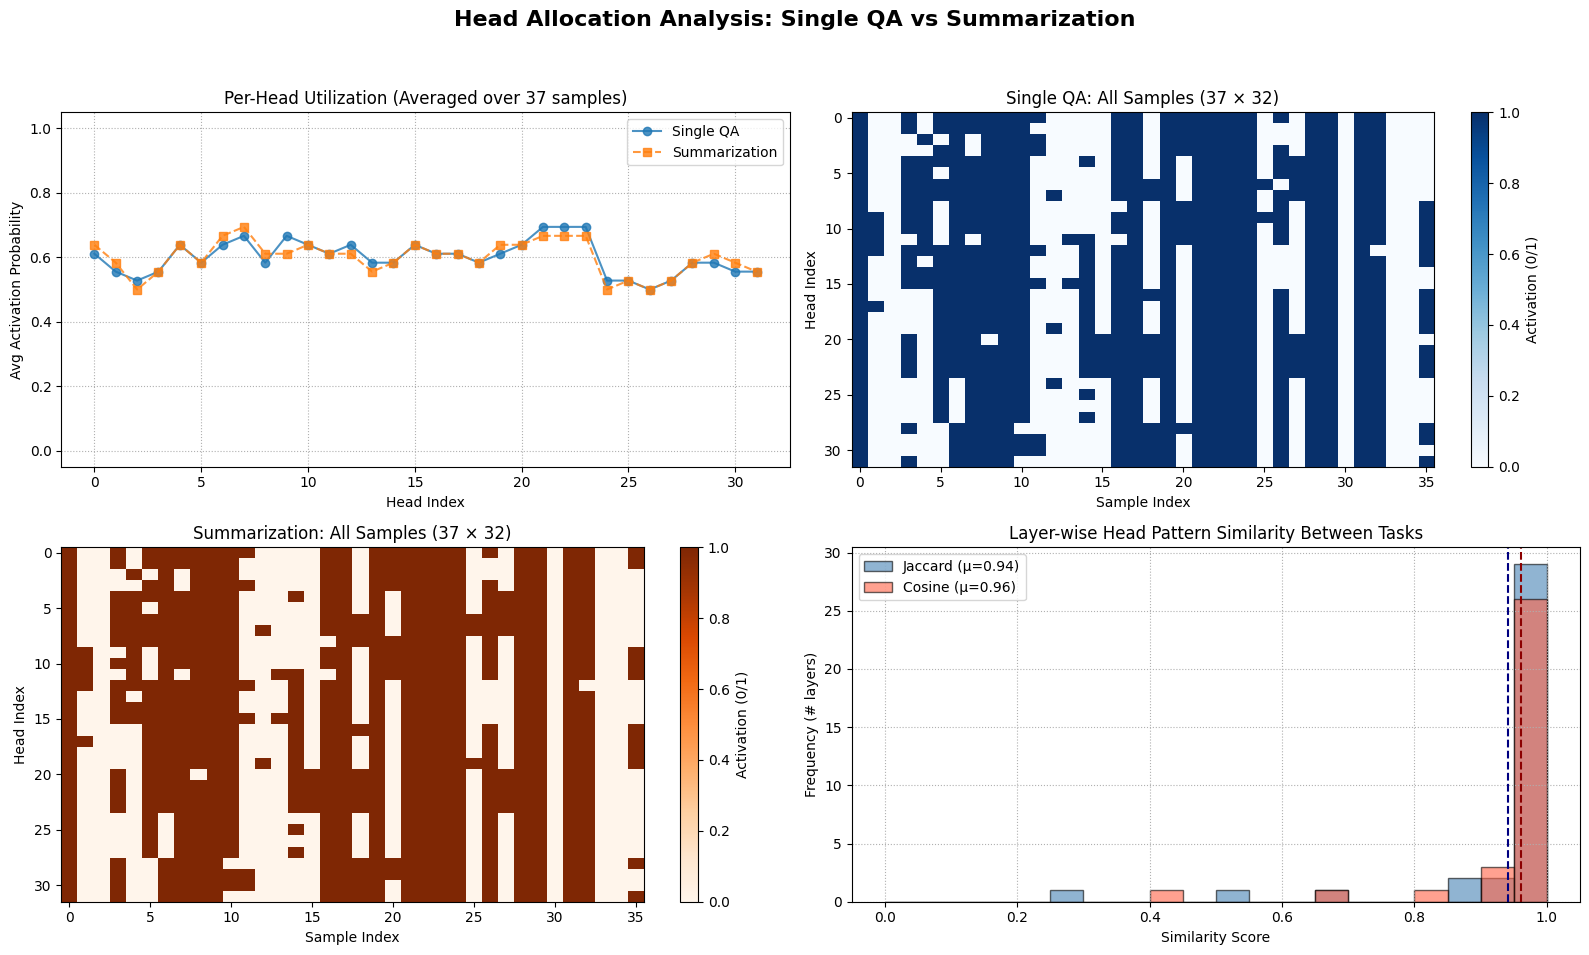

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine


# --- 2. Helper: Safe similarity ---
def safe_cosine(u, v):
    u_norm = np.linalg.norm(u)
    v_norm = np.linalg.norm(v)
    if u_norm == 0 and v_norm == 0:
        return 1.0
    if u_norm == 0 or v_norm == 0:
        return 0.0
    return np.dot(u, v) / (u_norm * v_norm)

jac_sim = []
cos_sim = []
for r1, r2 in zip(single_qa_array, summarization_array):
    # Jaccard: intersection / union
    inter = np.logical_and(r1, r2).sum()
    union = np.logical_or(r1, r2).sum()
    jac = inter / union if union > 0 else 1.0
    cos = safe_cosine(r1, r2)
    jac_sim.append(jac)
    cos_sim.append(cos)

jac_sim = np.array(jac_sim)
cos_sim = np.array(cos_sim)

print(f"Average Jaccard similarity: {jac_sim.mean():.3f} ± {jac_sim.std():.3f}")
print(f"Average Cosine similarity:  {cos_sim.mean():.3f} ± {cos_sim.std():.3f}")

# --- 3. Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Head Allocation Analysis: Single QA vs Summarization', fontsize=16, fontweight='bold')

# A. Mean head usage per task
single_mean = single_qa_array.mean(axis=0)
summar_mean = summarization_array.mean(axis=0)
x_heads = np.arange(32)
axes[0, 0].plot(x_heads, single_mean, 'o-', label='Single QA', alpha=0.8)
axes[0, 0].plot(x_heads, summar_mean, 's--', label='Summarization', alpha=0.8)
axes[0, 0].set_xlabel('Head Index')
axes[0, 0].set_ylabel('Avg Activation Probability')
axes[0, 0].set_title('Per-Head Utilization (Averaged over 37 samples)')
axes[0, 0].set_ylim(-0.05, 1.05)
axes[0, 0].grid(True, linestyle=':')
axes[0, 0].legend()

# B. Heatmap: Single QA (sample × head)
im1 = axes[0, 1].imshow(single_qa_array.T, aspect='auto', cmap='Blues', vmin=0, vmax=1)
axes[0, 1].set_title('Single QA: All Samples (37 × 32)')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Head Index')
plt.colorbar(im1, ax=axes[0, 1], label='Activation (0/1)')

# C. Heatmap: Summarization
im2 = axes[1, 0].imshow(summarization_array.T, aspect='auto', cmap='Oranges', vmin=0, vmax=1)
axes[1, 0].set_title('Summarization: All Samples (37 × 32)')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Head Index')
plt.colorbar(im2, ax=axes[1, 0], label='Activation (0/1)')

# D. Similarity histogram
bins = np.linspace(0, 1, 21)
axes[1, 1].hist(jac_sim, bins=bins, alpha=0.6, label=f'Jaccard (μ={jac_sim.mean():.2f})', color='steelblue', edgecolor='k')
axes[1, 1].hist(cos_sim, bins=bins, alpha=0.6, label=f'Cosine (μ={cos_sim.mean():.2f})', color='tomato', edgecolor='k')
axes[1, 1].axvline(jac_sim.mean(), color='navy', linestyle='--')
axes[1, 1].axvline(cos_sim.mean(), color='darkred', linestyle='--')
axes[1, 1].set_xlabel('Similarity Score')
axes[1, 1].set_ylabel('Frequency (# layers)')
axes[1, 1].set_title('Layer-wise Head Pattern Similarity Between Tasks')
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle=':')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()